<a href="https://colab.research.google.com/github/theouterlimitz/global-power-plant-database/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df_final = pd.read_pickle('analytical_data.pkl')
# ... continue with the rest of the EDA code ...

EDA Step 1: Analyze Water Stress by Fuel Type

The Question: How does baseline water stress differ across the most common types of power plants?

Loading the final analytical dataset...
Dataset loaded successfully.

Generating box plot of water stress scores by primary fuel type...


<ipython-input-2-be3a1eb81842>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_fuels,
<ipython-input-2-be3a1eb81842>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


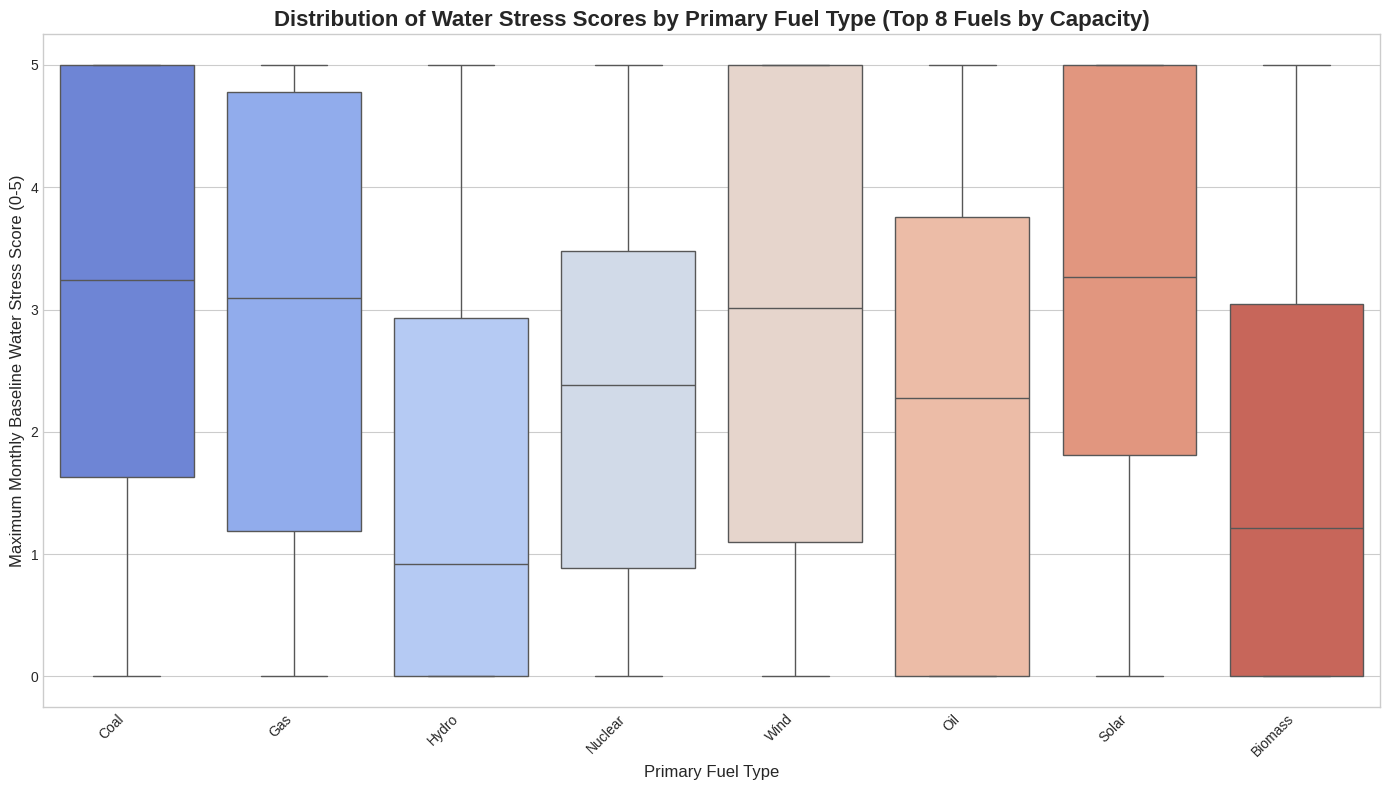

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Your Final Analytical Dataset ---
# We start here for all future analysis!
print("Loading the final analytical dataset...")
try:
    df_final = pd.read_pickle('analytical_data.pkl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'analytical_data.pkl' not found. Please ensure the file is in your Colab session.")
    # If the file is missing, you may need to re-run your Data Curation notebook to generate it.
    # Or upload it if you have it saved locally.


# --- Step 2: Prepare Data for this Analysis ---

# We already created the 'max_monthly_bws_score' and 'annual_bws_label'
# in our last script. Let's recreate them here to be safe.

# Identify all the monthly baseline water stress SCORE columns
bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
# For each power plant (row), find the maximum score it experiences across the 12 months
df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)

# For this plot, let's focus on the top 8 most common fuel types by capacity
top_fuels = df_final.groupby('primary_fuel')['capacity_mw'].sum().nlargest(8).index
df_top_fuels = df_final[df_final['primary_fuel'].isin(top_fuels)]


# --- Step 3: Visualize the Distribution ---
print("\nGenerating box plot of water stress scores by primary fuel type...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Create the box plot
sns.boxplot(data=df_top_fuels,
            x='primary_fuel',
            y='max_monthly_bws_score',
            ax=ax,
            order=top_fuels, # Ensure a consistent order
            palette='coolwarm')

ax.set_title('Distribution of Water Stress Scores by Primary Fuel Type (Top 8 Fuels by Capacity)', fontsize=16, fontweight='bold')
ax.set_xlabel('Primary Fuel Type', fontsize=12)
ax.set_ylabel('Maximum Monthly Baseline Water Stress Score (0-5)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

The Insight/Observation:

High-Risk Profiles: Coal, Gas, Solar, and Oil plants show the highest median water stress scores, indicating they are frequently sited in water-stressed regions.

Low-Risk Profile: Wind power stands out with a very low median water stress score, highlighting a key advantage in terms of water-related risk.

Mixed-Risk Profile: Hydropower has a lower median risk but a very wide distribution, reflecting its dependence on rivers in various climates.

Using 34595 plants with valid location and water stress data.
Sampling 5000 plants for mapping.

Generating world map of power plant water stress...


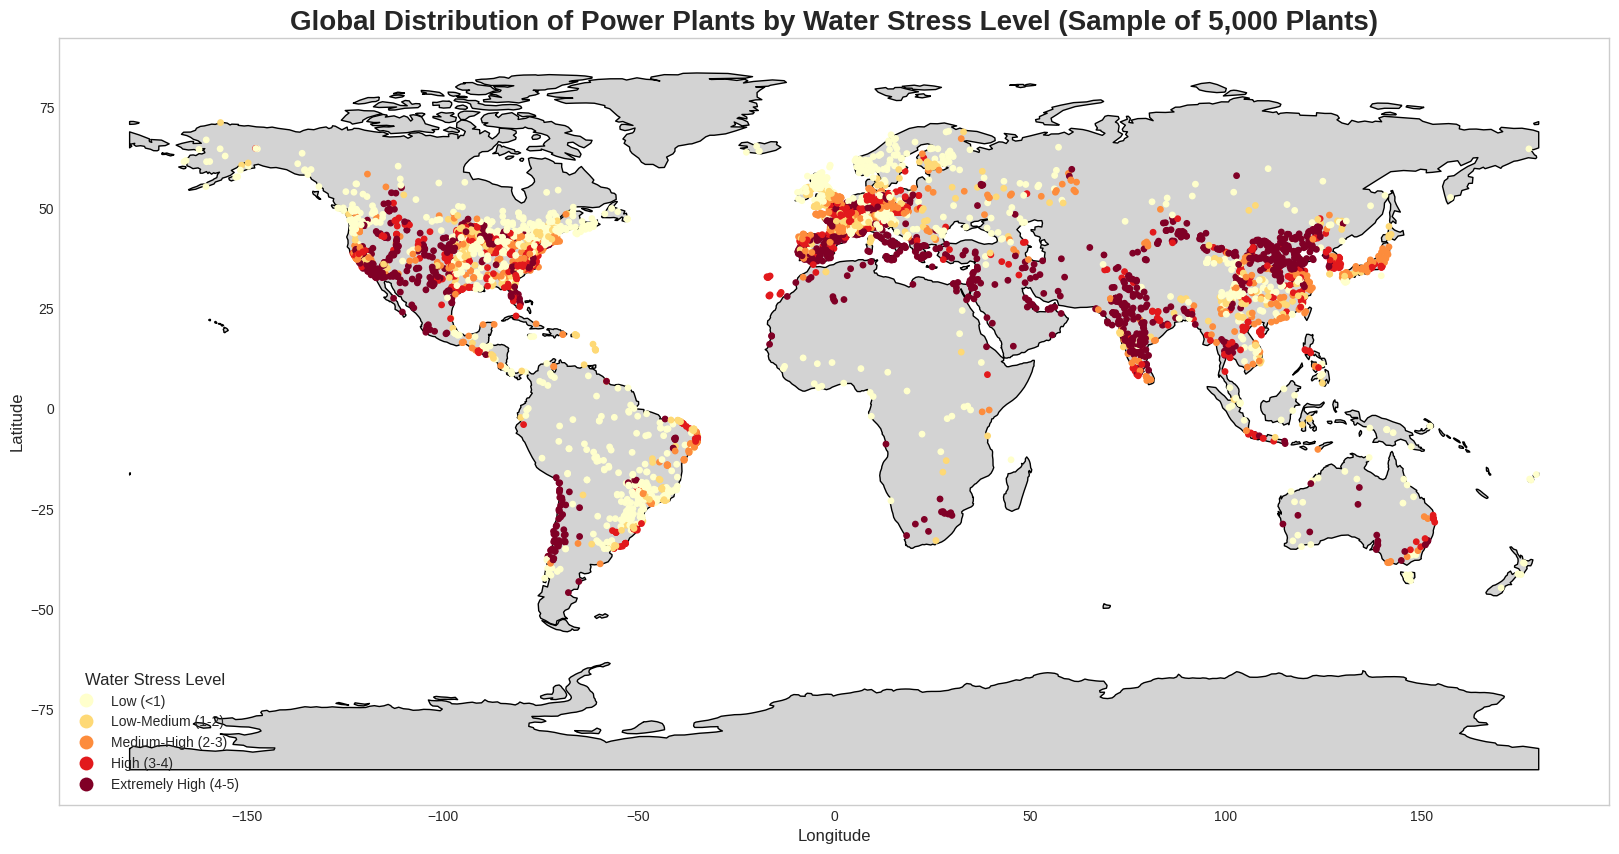

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# --- Assume df_final is already loaded from our previous step ---
# If you are in a new session, uncomment the line below to load your clean data
# df_final = pd.read_pickle('analytical_data.pkl')

# ===================================================================
# --- Step 1: Prepare the data for mapping ---
# ===================================================================

# If 'max_monthly_bws_score' doesn't exist, create it.
if 'max_monthly_bws_score' not in df_final.columns:
    print("Calculating 'max_monthly_bws_score'...")
    bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
    df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)

# Create a clear categorical label for the water stress score.
score_bins = [-1, 1, 2, 3, 4, 5.1]
score_labels = [
    'Low (<1)',
    'Low-Medium (1-2)',
    'Medium-High (2-3)',
    'High (3-4)',
    'Extremely High (4-5)'
]
df_final['annual_bws_label'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)

# Drop any plants that couldn't be matched or have no stress score for cleaner plotting.
df_for_map = df_final.dropna(subset=['annual_bws_label', 'geometry']).copy()
print(f"Using {len(df_for_map)} plants with valid location and water stress data.")

# Take a random sample to keep the map readable and fast to render.
df_sample = df_for_map.sample(n=min(5000, len(df_for_map)), random_state=42)
print(f"Sampling {len(df_sample)} plants for mapping.")


# ===================================================================
# --- Step 2: Create the World Map ---
# ===================================================================
print("\nGenerating world map of power plant water stress...")

# ** THE FINAL FIX IS HERE **
# We will load the world map directly from a reliable GeoJSON URL.
# This bypasses all local library and server download issues.
try:
    url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
    world = gpd.read_file(url)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 12))

    # Plot the base world map
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Plot the power plant data points on top
    df_sample.plot(ax=ax,
                   column='annual_bws_label',
                   categorical=True,
                   legend=True,
                   markersize=15,
                   cmap='YlOrRd',
                   legend_kwds={
                       'title': "Water Stress Level",
                       'loc': 'lower left',
                       'title_fontsize': '12',
                       'fontsize': '10'
                   })

    ax.set_title('Global Distribution of Power Plants by Water Stress Level (Sample of 5,000 Plants)', fontsize=20, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(False)

    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

"What is the fuel mix (in terms of total capacity) within each water stress category?"

Preparing data to analyze fuel mix by risk category...

Fuel Mix (in MW) by Water Stress Category:
primary_fuel             Biomass         Coal            Gas        Hydro  \
annual_bws_label                                                            
Low (<1)              19827.3884  348626.8780  278648.170600  671212.9620   
Low-Medium (1-2)       3791.2992  141730.9600  124296.563460  103435.8319   
Medium-High (2-3)      3517.4530  344001.9700  230474.986200   91826.2170   
High (3-4)             2868.2990  336237.0140  266259.449000   86444.8079   
Extremely High (4-5)   3854.6900  772942.9776  577959.138889   99552.9180   

primary_fuel            Nuclear            Oil          Solar        Wind  
annual_bws_label                                                           
Low (<1)              107453.00   38648.015090   19603.357325  50966.0834  
Low-Medium (1-2)       52601.00   23094.685000   14879.118105  27512.0239  
Medium-High (2-3)      92501.90   43299.235850   23085.83

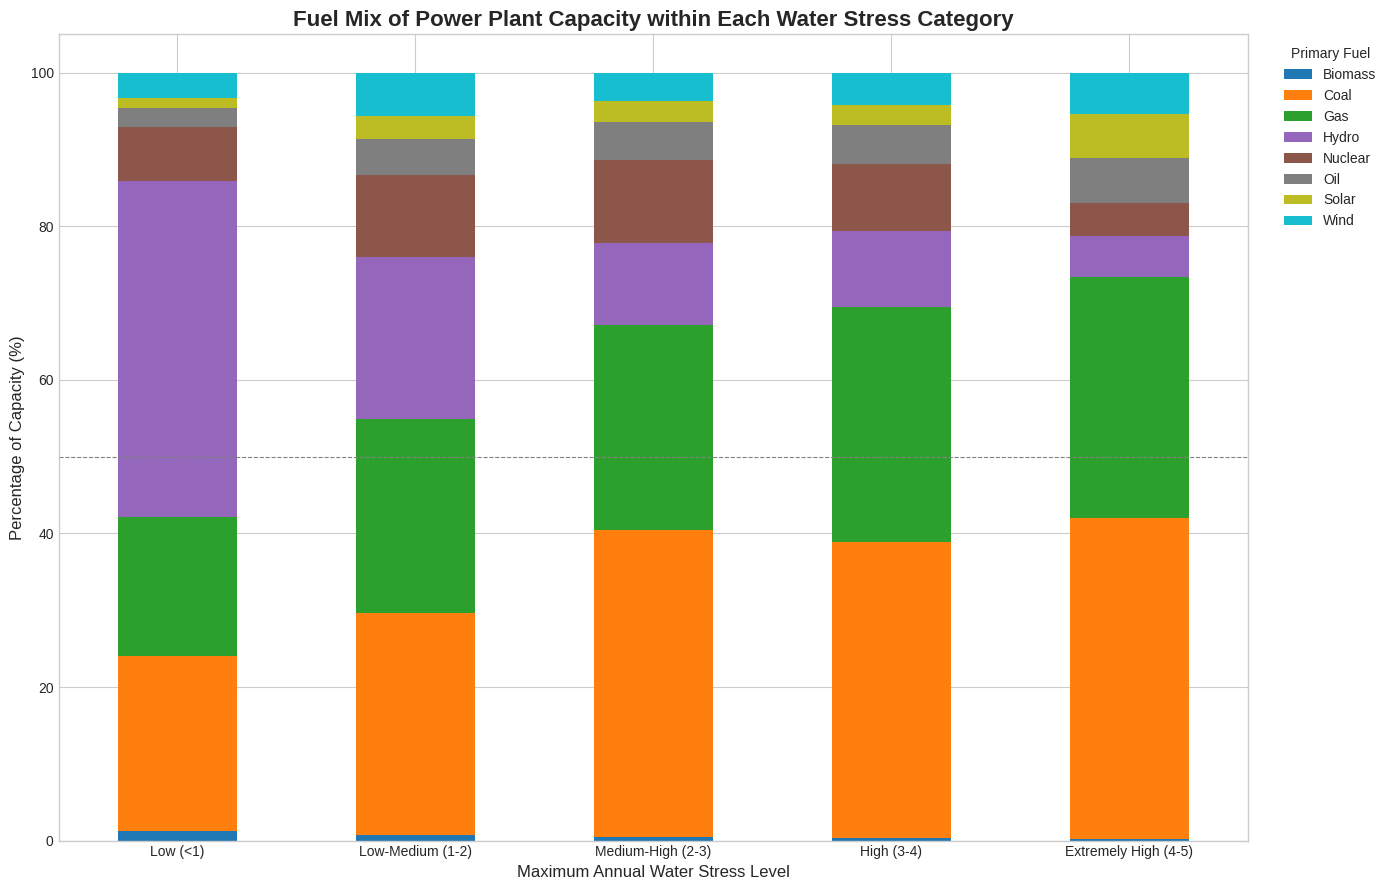

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_final is already loaded from our previous step ---
# If you are in a new session, uncomment the line below
# df_final = pd.read_pickle('analytical_data.pkl')

# ===================================================================
# --- Step 1: Prepare the data for this analysis ---
# ===================================================================
print("Preparing data to analyze fuel mix by risk category...")

# We'll use the same 'annual_bws_label' we created for the map
# And the 'top_fuels' list from the box plot analysis
top_fuels = df_final.groupby('primary_fuel')['capacity_mw'].sum().nlargest(8).index
df_top_fuels = df_final[df_final['primary_fuel'].isin(top_fuels)]

# Create a pivot table to get capacity for each fuel type within each risk category
fuel_risk_pivot = pd.crosstab(
    index=df_top_fuels['annual_bws_label'],
    columns=df_top_fuels['primary_fuel'],
    values=df_top_fuels['capacity_mw'],
    aggfunc='sum'
).fillna(0)

# Calculate percentages for a 100% stacked bar chart
fuel_risk_pivot_perc = fuel_risk_pivot.div(fuel_risk_pivot.sum(axis=1), axis=0) * 100

print("\nFuel Mix (in MW) by Water Stress Category:")
print(fuel_risk_pivot)


# ===================================================================
# --- Step 2: Visualize the Fuel Mix ---
# ===================================================================
print("\nGenerating stacked bar chart...")

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 9))
fuel_risk_pivot_perc.plot(kind='bar', stacked=True, ax=ax, cmap='tab10')

# Formatting the plot
ax.set_title('Fuel Mix of Power Plant Capacity within Each Water Stress Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Maximum Annual Water Stress Level', fontsize=12)
ax.set_ylabel('Percentage of Capacity (%)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Primary Fuel', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add a horizontal line at 50% for reference
ax.axhline(50, color='grey', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()